In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cmdstanpy

C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
url = "https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/drp_scores.csv"
# Treatment and response data for a study on the effect of a treatment
data_str = """
Treatment	Response
Treated	24
Treated	43
Treated	58
Treated	71
Treated	43
Treated	49
Treated	61
Treated	44
Treated	67
Treated	49
Treated	53
Treated	56
Treated	59
Treated	52
Treated	62
Treated	54
Treated	57
Treated	33
Treated	46
Treated	43
Treated	57
Control	42
Control	43
Control	55
Control	26
Control	62
Control	37
Control	33
Control	41
Control	19
Control	54
Control	20
Control	85
Control	46
Control	10
Control	17
Control	60
Control	53
Control	42
Control	37
Control	42
Control	55
Control	28
Control	48
"""

In [9]:
from io import StringIO

data = StringIO(data_str)
df = pd.read_csv(data, sep="\t")
df.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


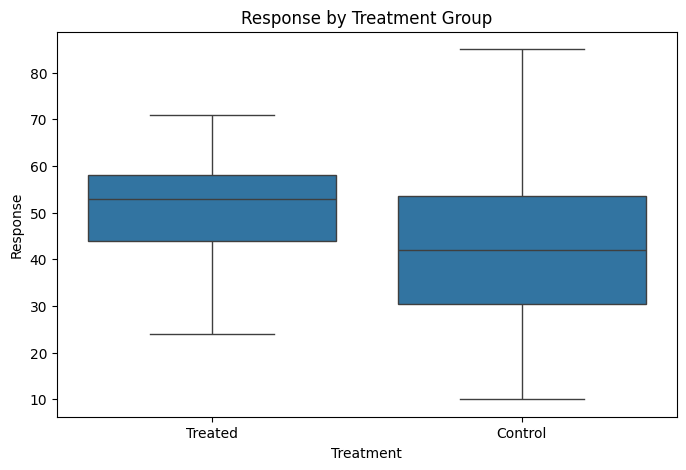

In [22]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Treatment", y="Response", data=df)
plt.title("Response by Treatment Group")
plt.show()

In [16]:
grouped = df.groupby("Treatment")
responses = {}
for name, group in grouped:
    responses[name] = group["Response"]
print(responses["Treated"])

0     24
1     43
2     58
3     71
4     43
5     49
6     61
7     44
8     67
9     49
10    53
11    56
12    59
13    52
14    62
15    54
16    57
17    33
18    46
19    43
20    57
Name: Response, dtype: int64


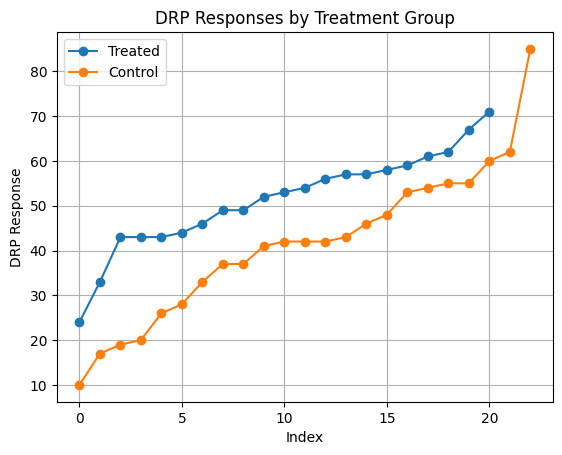

In [29]:
plt.plot(responses["Treated"], 'o-', label="Treated")
plt.plot(responses["Control"], 'o-', label="Control")
plt.legend(); plt.grid();
plt.title("DRP Responses by Treatment Group")
plt.ylabel("DRP Response")
plt.xlabel("Index");

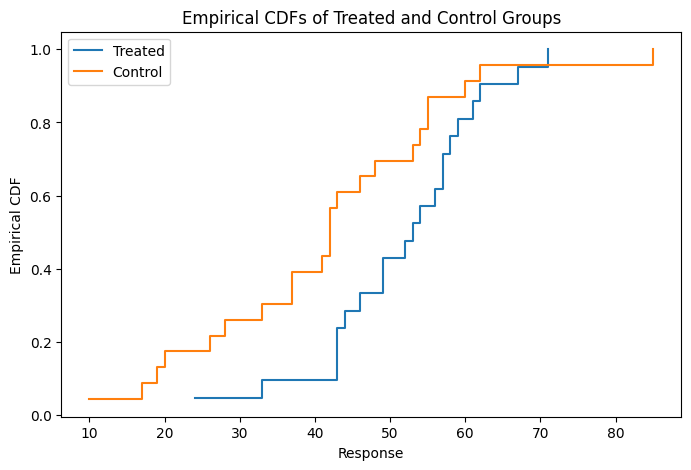

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

# Data must be sorted to use ECDF
responses["Treated"] = sorted(responses["Treated"])
responses["Control"] = sorted(responses["Control"])

ecdf_treated = ECDF(responses["Treated"])
ecdf_control = ECDF(responses["Control"])

# ecdf_treated(x) returns  CDF(x) for the treated group
# ecdf_control(x) returns  CDF(x) for the control group

plt.figure(figsize=(8, 5))
plt.step(responses["Treated"], ecdf_treated(responses["Treated"]), label="Treated", where='post')
plt.step(responses["Control"], ecdf_control(responses["Control"]), label="Control", where='post')
plt.xlabel("Response")
plt.ylabel("Empirical CDF")
plt.legend()
plt.title("Empirical CDFs of Treated and Control Groups")
plt.show()

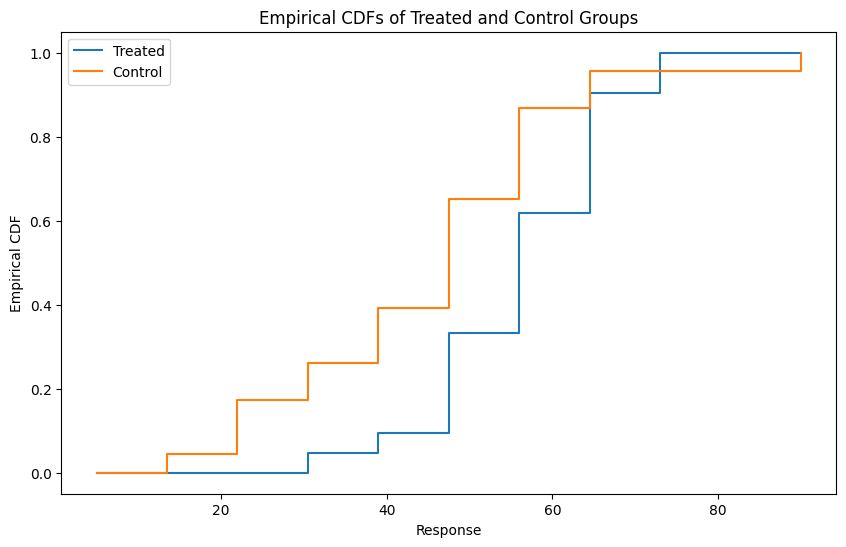

In [21]:
res = np.linspace(5, 90, 11)
plt.figure(figsize=(10, 6))
plt.step(res, ecdf_treated(res), label="Treated", where='post')
plt.step(res, ecdf_control(res), label="Control", where='post')
plt.xlabel("Response")
plt.ylabel("Empirical CDF")
plt.legend()
plt.title("Empirical CDFs of Treated and Control Groups")
plt.show()

In [31]:
np.std(responses["Treated"]), np.std(responses["Control"])

(np.float64(10.742080350166495), np.float64(16.771791963623848))

The exponential(1) prior in Stan has a mean and standard deviation of 1, and its density decreases rapidly for larger values. While it technically allows any positive value, it strongly favors small values (most mass is near zero).

For data, where the sample standard deviations are about 10 and 16, exponential(1) puts very little prior probability on such large values. This can make the model underestimate the true standard deviation, especially with limited data.

If you expect σ to be around 10–16, consider a weaker prior, such as exponential(0.1) (mean 10), or a half-normal prior like normal(0, 20) with lower bound 0. These priors better cover the range of your observed data.

Another option is that you can use a `gamma` distribution as a prior for the standard deviation (σ) in Stan. The gamma distribution is flexible and can be tuned to match your prior beliefs about the scale of σ.

For example, if you expect σ to be around 10–16, you might use:
```
sigma1 ~ gamma(shape, rate)
```
Choose shape and rate so that the mean (shape/rate) matches your expectation. For example, gamma(2, 0.2) has mean 10 and standard deviation about 7.07.

In Stan, the gamma distribution is parameterized as gamma(shape, rate) (mean = shape/rate, variance = shape/rate^2).

In [33]:
# Stan model for comparing means of two groups
stan_code = """
data {
    int<lower=0> N1;         // number of treated samples
    int<lower=0> N2;         // number of control samples
    vector[N1] y1;           // treated responses
    vector[N2] y2;           // control responses
}
parameters {
    real mu1;                // mean of treated
    real mu2;                // mean of control
    real<lower=0> sigma1;    // std dev of treated
    real<lower=0> sigma2;    // std dev of control
}
model {
    mu1 ~ normal(0, 100);
    mu2 ~ normal(0, 100);
    sigma1 ~ exponential(.1);
    sigma2 ~ exponential(.1);
    y1 ~ normal(mu1, sigma1);
    y2 ~ normal(mu2, sigma2);
}
generated quantities {
    real diff_means = mu1 - mu2;
}
"""

# Save Stan model to file
stan_file = "compare_means.stan"
with open(stan_file, "w") as f:
    f.write(stan_code)

# Prepare data for Stan
stan_data = {
    "N1": len(responses["Treated"]),
    "N2": len(responses["Control"]),
    "y1": np.array(responses["Treated"]),
    "y2": np.array(responses["Control"])
}

# Compile and sample using cmdstanpy
model = cmdstanpy.CmdStanModel(stan_file=stan_file)
fit = model.sample(data=stan_data, chains=4, iter_sampling=1000, iter_warmup=500, seed=42)
#

10:33:55 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\tb2\compare_means.stan to exe file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\tb2\compare_means.exe
10:34:03 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\tb2\compare_means.exe
10:34:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


10:34:05 - cmdstanpy - INFO - CmdStan done processing.


In [35]:
# Extract posterior samples
posterior = fit.draws_pd()
print(posterior[["mu1", "mu2", "sigma1", "sigma2", "diff_means"]].describe())

               mu1          mu2       sigma1       sigma2   diff_means
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000
mean     51.428275    41.446752    11.386784    17.514852     9.981522
std       2.503691     3.644589     1.825538     2.757912     4.452927
min      42.336800    28.874000     6.472580    10.563700    -5.081000
25%      49.768150    39.101250    10.127200    15.589200     6.988638
50%      51.451550    41.425450    11.167000    17.171900     9.981585
75%      53.091750    43.867625    12.435850    19.060825    12.984025
max      61.798200    54.740900    20.481400    33.902800    23.603100


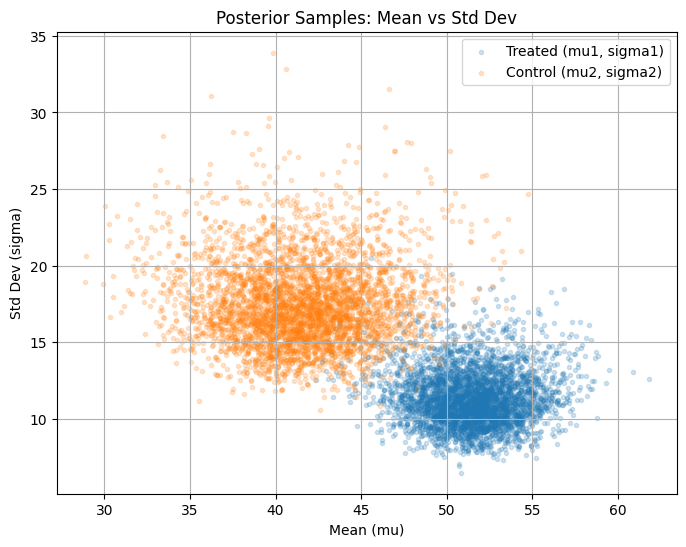

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(posterior["mu1"], posterior["sigma1"], 
            marker='.', alpha=0.2, label="Treated (mu1, sigma1)")
plt.scatter(posterior["mu2"], posterior["sigma2"], 
            marker='.', alpha=0.2, label="Control (mu2, sigma2)")
plt.xlabel("Mean (mu)")
plt.ylabel("Std Dev (sigma)")
plt.legend()
plt.title("Posterior Samples: Mean vs Std Dev")
plt.grid(True)
plt.show()

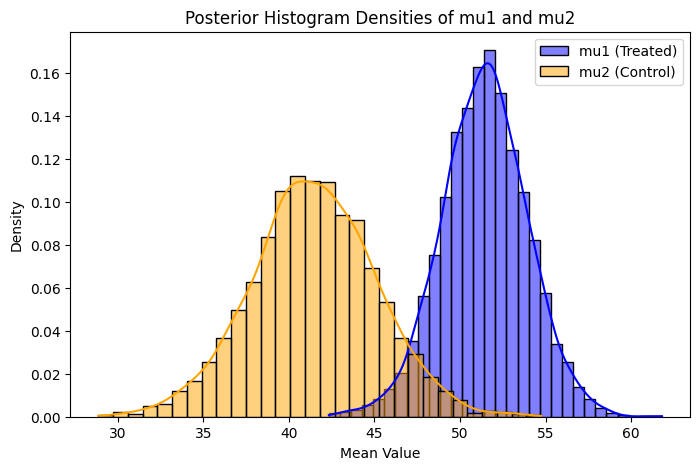

In [45]:
plt.figure(figsize=(8, 5))
sns.histplot(posterior["mu1"], kde=True, label="mu1 (Treated)", stat="density", bins=30, color="blue", alpha=0.5)
sns.histplot(posterior["mu2"], kde=True, label="mu2 (Control)", stat="density", bins=30, color="orange", alpha=0.5)
plt.xlabel("Mean Value")
plt.ylabel("Density")
plt.title("Posterior Histogram Densities of mu1 and mu2")
plt.legend()
plt.show()

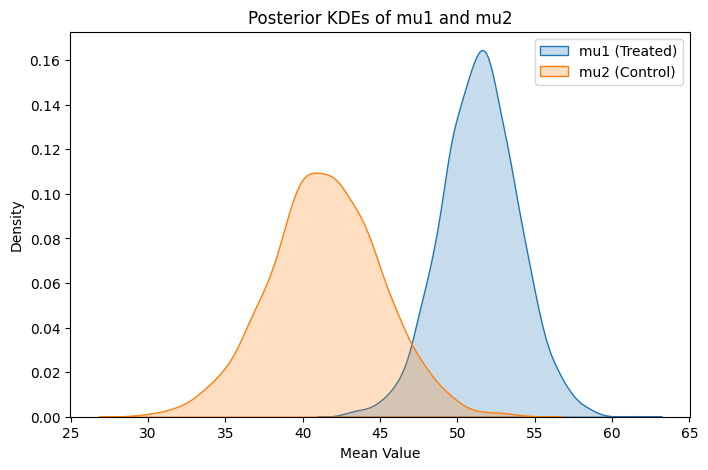

In [41]:
plt.figure(figsize=(8, 5))
sns.kdeplot(posterior["mu1"], label="mu1 (Treated)", fill=True)
sns.kdeplot(posterior["mu2"], label="mu2 (Control)", fill=True)
plt.xlabel("Mean Value")
plt.ylabel("Density")
plt.title("Posterior KDEs of mu1 and mu2")
plt.legend()
plt.show()

In [48]:
prob = np.mean(posterior["mu1"] > posterior["mu2"])
print(f"Probability that mu1 > mu2: {prob:.3f}")

Probability that mu1 > mu2: 0.984


Comparing the marginal distributions for the two groups, it looks like the population mean in the treated group is higher. We can compute the probability of superiority
- There is a 98% chance that the mean in the treated group is higher.

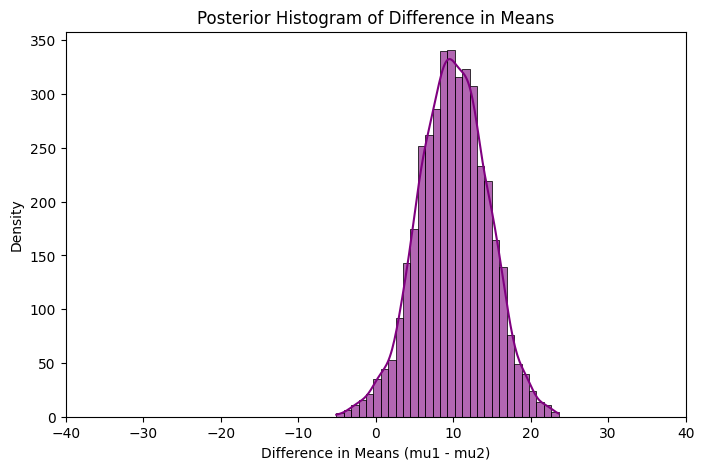

In [53]:
plt.figure(figsize=(8, 5))
plt.xlim(-40, 40)
sns.histplot(posterior["diff_means"], kde=True, bins=30, color="purple", alpha=0.6)
plt.xlabel("Difference in Means (mu1 - mu2)")
plt.ylabel("Density")
plt.title("Posterior Histogram of Difference in Means")
plt.show()